# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель:** построить модель для определения стоимости атвомобиля на основе признаков.

**Задачи:**
1. Изучить и подготовить данные.
2. Обучить разные модели с различными гиперпараметрами.
3. Проанализировать скорость работы и качество моделей и сделать вывод.

**Описание данных:**

Признаки: 

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
*`LastSeen` — дата последней активности пользователя

Целевой признак:
* `Price` — цена (евро)

**План выволнения работы:**
1. Загрузка данных.
2. Предобработка данных.
2. Обучение моделей.
* CatBoost
* Ridge
* LightGBM
3. Анализ моделей.

## Загрузка данных

In [2]:
import warnings

from scipy.sparse import csr_matrix
import pandas as pd
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
df = pd.read_csv(r'~/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


* Признакми `NumberOfPictures`, `PostalCode`, `LastSeen `, `DateCreated`, `DateCrawled `  не несут смысловой нагрузки, поэтому их можно удалить. 
* `RegistrationMonth`- это избыточная информация, есть столбец `RegistrationYear`.
* В датасете присутствуют пропуски, нужно будет их устранить.

## Предобработка данных

* приведем к нижнему регистру.
* проверим на дубликаты.
* проверим на пропуски и выбросы.
* отберем нужные признаки для построения модели.

In [5]:
df.columns =  df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [6]:
df = df.drop(['numberofpictures', 'postalcode', 'registrationmonth', 'datecrawled', 'datecreated', 'lastseen'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             354369 non-null  int64 
 1   vehicletype       316879 non-null  object
 2   registrationyear  354369 non-null  int64 
 3   gearbox           334536 non-null  object
 4   power             354369 non-null  int64 
 5   model             334664 non-null  object
 6   kilometer         354369 non-null  int64 
 7   fueltype          321474 non-null  object
 8   brand             354369 non-null  object
 9   repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [8]:
sum(df.duplicated())

45040

In [9]:
df = df.drop_duplicates()

In [10]:
df.isna().sum()

price                   0
vehicletype         34559
registrationyear        0
gearbox             17207
power                   0
model               18361
kilometer               0
fueltype            30764
brand                   0
repaired            64558
dtype: int64

**Признак `model`**

Этот признак является одним из основных в предсказании цены, поэтому строки с пропусками удалим. И посмотрим на уникальные значения.

In [11]:
df = df.loc[~df['model'].isna()]
df['model'].unique()

array(['golf', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox', 'ma

Здесь присутствуют неявные дубликаты. Устраним их.

In [12]:
replacements = {
    '3er': '3_reihe',
    '5er': '5_reihe',
    '6er': '6_reihe',
    '7er': '7_reihe',
    'a_klasse': 'a-klasse',
    'b_klasse': 'b-klasse',
    'c_klasse': 'c-klasse',
    'e_klasse': 'e-klasse',
    's_klasse': 's-klasse',
    'x_reihe': 'x-reihe',
    'xc_reihe': 'xc-reihe',
    'i_reihe': 'i-reihe',
    'cr_reihe': 'cr-reihe',
    'mx_reihe': 'mx-reihe',
    'rx_reihe': 'rx-reihe',
    'q_reihe': 'q-reihe',
    'cx_reihe': 'cx-reihe',
    'v_klasse': 'v-klasse',
    'm_klasse': 'm-klasse',
    'g_klasse': 'g-klasse',
    'kaefer': 'beetle',
    'range_rover': 'range_rover',
    'rangerover': 'range_rover',
    'range_rover_sport': 'range_rover',
    'range_rover_evoque': 'range_rover',
    'serie_2': 'serie-2',
    'serie_3': 'serie-3',
    'serie_1': 'serie-1'
}

df['model'] = df['model'].apply(lambda x: re.sub('|'.join(replacements.keys()), lambda m: replacements[m.group()], x).lower())

df['model'].unique()

array(['golf', 'grand', 'fabia', '3_reihe', '2_reihe', 'other', 'c_max',
       'passat', 'navara', 'ka', 'polo', 'twingo', 'a-klasse', 'scirocco',
       '5_reihe', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e-klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b-klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c-klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc-reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7_reihe', '80',
       '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza',
       'mustang', 'eos', 'touran', 'getz', 'a3', 'almera', 'megane',
       'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'berlingo', 'tiguan', 'i-reihe', 'espace',
       'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed', 'yeti',
       'octavia', 'mii', 'rx-reihe', 'modus', 'fox', 'matiz', 'beetle',
 

Построим график топ-10 моделей для наглядности.

In [13]:
def bar_plot(df, column):
    
    model_counts = df[column].value_counts().head(10)

    sns.barplot(x=model_counts.index, y=model_counts.values)
    plt.title('Топ 10 моделей автомобилей')
    plt.xlabel(column)
    plt.ylabel('Количество') 
    plt.show()

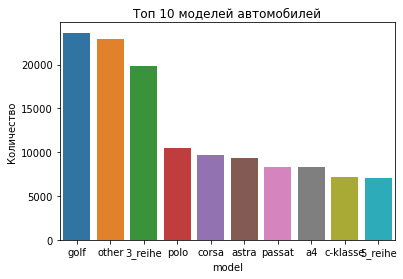

In [14]:
bar_plot(df, 'model')

**Признак `vehicletype`, `gearbox`, `fueltype`**

Заменим пропуски на значение 'unknown', так как другие могут исказить данные.

In [15]:
df['vehicletype'].unique()

array([nan, 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'coupe', 'other'], dtype=object)

Заменим значения nan наиболее распространенными значениями для тех же моделей.

In [16]:
df['vehicletype'] = df['vehicletype'].fillna('unknown')

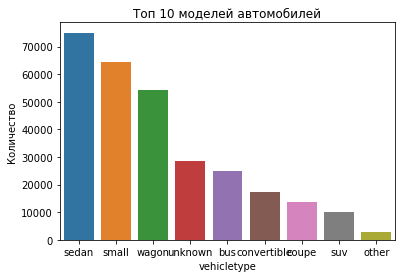

In [17]:
bar_plot(df, 'vehicletype')

In [18]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [19]:
df['gearbox'] = df['gearbox'].fillna('unknown')

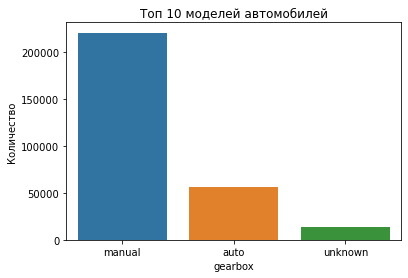

In [20]:
bar_plot(df, 'gearbox')

In [21]:
df['fueltype'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Мы заменим petrol на gasoline, так как это одно и то же: 
* Petrol - это британское название бензина.
* Gasoline - это американское название бензина.

In [22]:
df['fueltype'] = df['fueltype'].fillna('unknown')
df['fueltype'] = df['fueltype'].replace('petrol', 'gasoline')

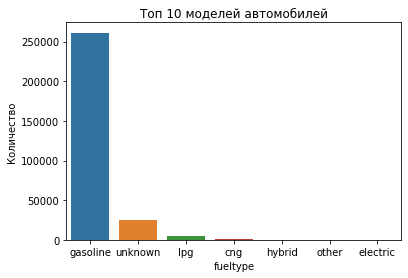

In [23]:
bar_plot(df, 'fueltype')

In [24]:
df['fueltype'].value_counts()

gasoline    261150
unknown      24360
lpg           4559
cng            507
hybrid         197
other          130
electric        65
Name: fueltype, dtype: int64

In [25]:
df.isna().sum()

price                   0
vehicletype             0
registrationyear        0
gearbox                 0
power                   0
model                   0
kilometer               0
fueltype                0
brand                   0
repaired            56386
dtype: int64

**Признак `Power`**

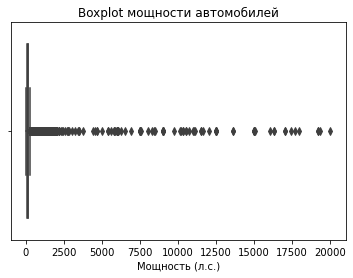

In [26]:
sns.boxplot(data=df, x='power')
plt.title('Boxplot мощности автомобилей')
plt.xlabel('Мощность (л.с.)')
plt.show()

Видим аномальные значения.

<AxesSubplot:xlabel='power', ylabel='Count'>

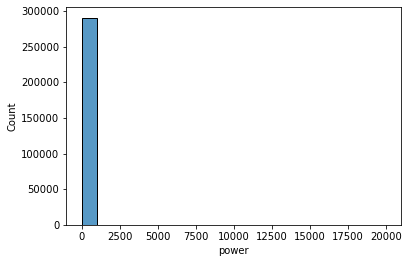

In [27]:
sns.histplot(df['power'], bins =20)

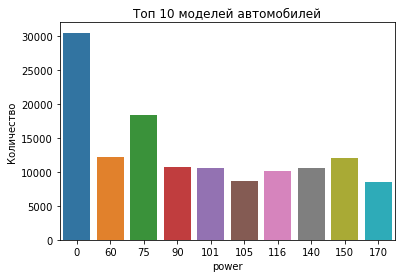

In [28]:
bar_plot(df, 'power')

Установим границы аномальных значений: менее 40 и более 600 л.с. Избавимся от таких значений.

In [29]:
df.loc[(df['power'] > 600) | (df['power'] < 40)] = None

In [30]:
df = df.loc[~df['power'].isna()]

<AxesSubplot:xlabel='power', ylabel='Count'>

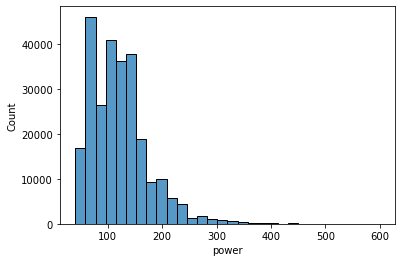

In [31]:
sns.histplot(df['power'], bins = 30)

**Признак `repaired`**

In [32]:
df['repaired'] = df['repaired'].fillna('unknown')

In [34]:
df.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

**Признак `price`**

<AxesSubplot:xlabel='price', ylabel='Count'>

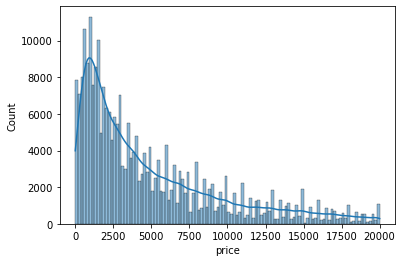

In [35]:
sns.histplot(data=df, x='price', kde=True)

<AxesSubplot:xlabel='power'>

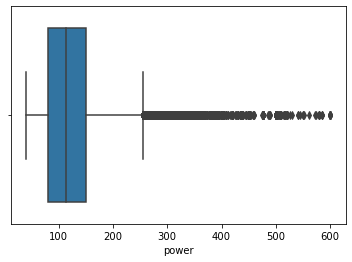

In [36]:
sns.boxplot(data=df, x='power')

Это целевой признак, поэтому строки с нулевым значением удалим.

In [37]:
df = df[df['price'] >= 100] 

In [38]:
df['price'].min()

100.0

<AxesSubplot:xlabel='price', ylabel='Count'>

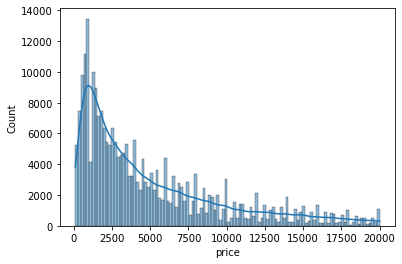

In [39]:
sns.histplot(data=df, x='price', kde=True)

Видим, что большинство авто продают примерно за 1300 евро.

**Признак `registrationyear`**

Построим boxplot и histplot, чтобы посмотреть на наличие выбросов и аномалий.

(0.0, 2000.0)

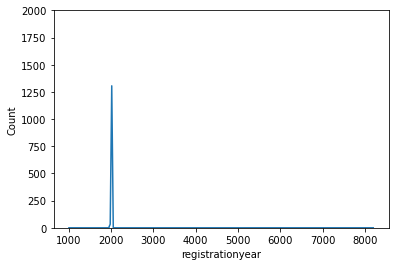

In [41]:
sns.histplot(data=df, x='registrationyear', kde=True)
plt.ylim(0, 2000) 

<AxesSubplot:xlabel='registrationyear'>

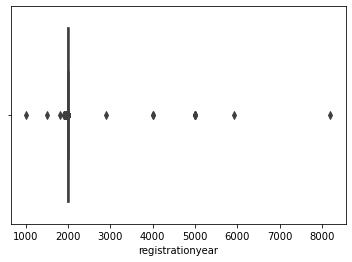

In [42]:
sns.boxplot(data=df, x='registrationyear')

Наблюдаем единичные аномалии.

In [43]:
df['registrationyear'].describe()

count    253134.000000
mean       2003.643778
std          21.790707
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        8200.000000
Name: registrationyear, dtype: float64

Чтобы избежать проблем с предсказанием цен из-за неправильно указанных годов регистрации, стоит удалить такие объявления. Верхнюю границу возьмем 2016, когда был выгружен датасет, и нижнюю 1883, так как у нас нет никаких данных насчет этого, то возьмем год создания автомобиля.

In [44]:
df= df.loc[(df['registrationyear'] <=2016) & (df['registrationyear'] >= 1885)]

<AxesSubplot:xlabel='registrationyear'>

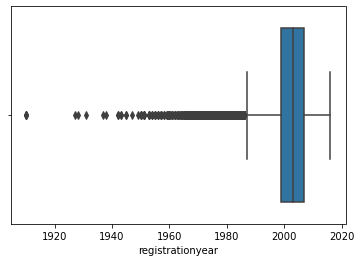

In [45]:
sns.boxplot(data=df, x='registrationyear')

Видим, что присутствуют единичные выбросы. Возможно, это антиквариатные автомобили?

<AxesSubplot:xlabel='registrationyear', ylabel='Count'>

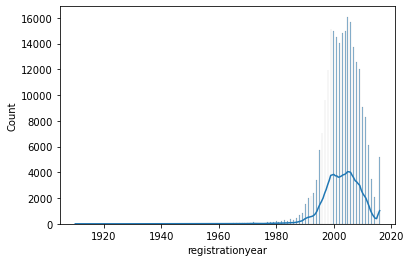

In [46]:
sns.histplot(data=df, x='registrationyear', kde=True)

**Признак `kilometer`**

In [47]:
df['kilometer'].describe()

count    244796.000000
mean     127346.423144
std       37134.281264
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

<AxesSubplot:xlabel='kilometer', ylabel='Count'>

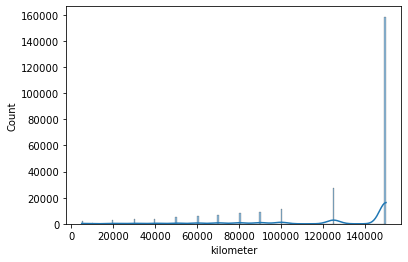

In [48]:
sns.histplot(data=df, x='kilometer', kde=True)

Данные выглядят чистыми.

In [50]:
df.isna().sum()

price               0
vehicletype         0
registrationyear    0
gearbox             0
power               0
model               0
kilometer           0
fueltype            0
brand               0
repaired            0
dtype: int64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244796 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             244796 non-null  float64
 1   vehicletype       244796 non-null  object 
 2   registrationyear  244796 non-null  float64
 3   gearbox           244796 non-null  object 
 4   power             244796 non-null  float64
 5   model             244796 non-null  object 
 6   kilometer         244796 non-null  float64
 7   fueltype          244796 non-null  object 
 8   brand             244796 non-null  object 
 9   repaired          244796 non-null  object 
dtypes: float64(4), object(6)
memory usage: 20.5+ MB


Построим матрицу корреляции.

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer']


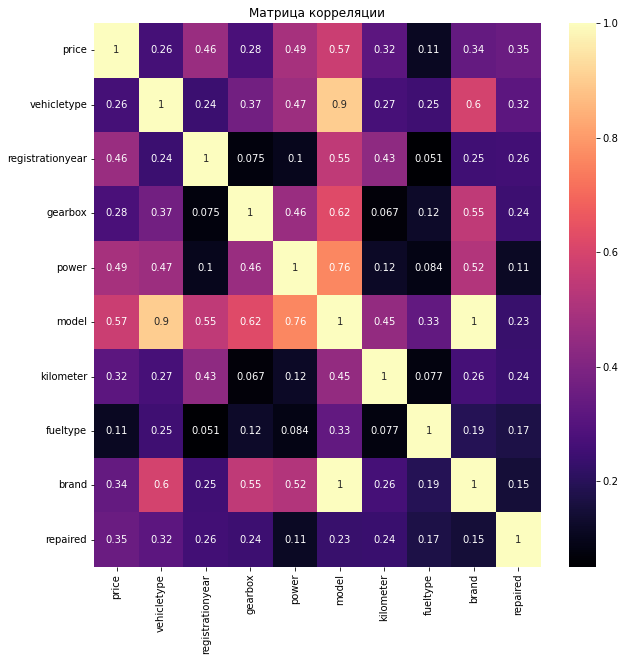

In [52]:
matrix_corr = df.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_corr, annot=True, cmap='magma')
plt.title('Матрица корреляции')
plt.show()

Наблюдаем сильную корреляцию между model и vehicletype, model и brand. 
Объединим model и brand и закодируем.

In [53]:
df0 = df.copy()
df0['brand_model'] = df0['brand'].astype(str) + ' ' + df0['model'].astype(str)
df0['model_code'] = df0['brand_model'].map(df0.groupby('brand_model').size()) / \
                     df0['brand'].map(df0.groupby('brand').size())

In [54]:
df1 =df0.drop(['brand_model', 'model', 'brand'], axis=1)

In [55]:
df1.head()

,price,vehicletype,registrationyear,gearbox,power,kilometer,fueltype,repaired,model_code
2,9800.0,suv,2004.0,auto,163.0,125000.0,gasoline,unknown,0.381853
3,1500.0,small,2001.0,manual,75.0,150000.0,gasoline,no,0.391504
4,3600.0,small,2008.0,manual,69.0,90000.0,gasoline,no,0.386654
5,650.0,sedan,1995.0,manual,102.0,150000.0,gasoline,yes,0.551731
6,2200.0,convertible,2004.0,manual,109.0,150000.0,gasoline,no,0.480098


Посмотрим теперь на матрицу корреляции.

interval columns not set, guessing: ['price', 'registrationyear', 'power', 'kilometer', 'model_code']


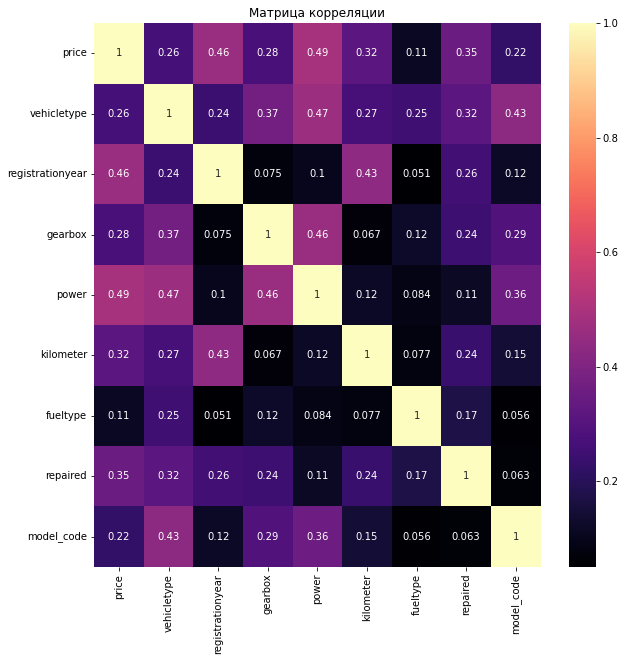

In [56]:
matrix_corr = df1.phik_matrix()
plt.figure(figsize=(10, 10))
sns.heatmap(matrix_corr, annot=True, cmap='magma')
plt.title('Матрица корреляции')
plt.show()

Больше не наблюдается мультиколлинеарность.

**Вывод:** мы выполнили предобработку данных, которая включала в себя привидение столбцов к нижнему регистру, проверку на дубли, аномалии, выбросы - все это мы устранили. Также была обнаружена мультиколлинеарность, которую убрали с помощью объединения столбцов model и brand и последующей их кодировкой. Таким образом, корреляция упала с 0.90 до 0.43.

## Обучение моделей

### CatBoost

In [57]:
frame = df1.copy()

In [58]:
X = frame.drop(['price'], axis=1)
y = frame['price']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE
                                                   )

In [59]:
#категориальные признаки 
ohe_features_cat = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_cat)

['vehicletype', 'gearbox', 'fueltype', 'repaired']


In [60]:
#численные признаки
num_features_cat = X_train.select_dtypes(exclude='object').columns.to_list()
num_features_cat

['registrationyear', 'power', 'kilometer', 'model_code']

In [61]:
X_train.columns

Index(['vehicletype', 'registrationyear', 'gearbox', 'power', 'kilometer',
       'fueltype', 'repaired', 'model_code'],
      dtype='object')

In [62]:
X_train_cat = X_train.copy()
#X_test_cat = X_test.copy()

In [63]:
encoder_ohe_cat = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe_cat.fit(X_train_cat[ohe_features_cat])
X_train_cat[encoder_ohe_cat.get_feature_names_out()] = encoder_ohe_cat.transform(X_train_cat[ohe_features_cat])
X_train_cat = X_train_cat.drop(ohe_features_cat, axis=1)

In [64]:
scaler = StandardScaler()
X_train_cat[num_features_cat] = scaler.fit_transform(X_train_cat[num_features_cat])
X_train_cat.head()

,registrationyear,power,kilometer,model_code,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,gearbox_manual,gearbox_unknown,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_unknown,repaired_unknown,repaired_yes
338685,-0.954936,-0.112423,0.610337,1.816608,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
69813,-1.426788,-0.131087,0.610337,-0.204017,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
154041,1.247038,-0.112423,-1.806809,-0.618925,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
78244,-1.741356,0.522152,0.610337,-1.203084,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4593,-0.011233,-0.355055,-0.732522,-0.969761,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Приступим к обучению модели.

In [65]:
cat = CatBoostRegressor(depth=5, learning_rate=0.6)

In [66]:
param_dist = {
    'depth': [5, 7],
    'learning_rate': [0.1, 0.6],
    'iterations': [100, 150]
}

# Определяем метрику RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Настраиваем RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=cat,
                                   param_distributions=param_dist,
                                   n_iter=50,  # Количество итераций
                                   scoring=rmse_scorer,
                                   cv=5,
                                   verbose=1,
                                   random_state=RANDOM_STATE)

# Обучаем модель
random_search.fit(X_train_cat, y_train)

# Выводим лучшие параметры и лучшую модель
print("Лучшие параметры:", random_search.best_params_)
print("Лучший RMSE:", random_search.best_score_)

# Получаем лучшую модель
best_model = random_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 4381.6150474	total: 147ms	remaining: 14.5s
1:	learn: 4122.9402739	total: 157ms	remaining: 7.68s
2:	learn: 3885.9488787	total: 166ms	remaining: 5.37s
3:	learn: 3678.0374430	total: 176ms	remaining: 4.22s
4:	learn: 3503.2596958	total: 186ms	remaining: 3.53s
5:	learn: 3343.0051302	total: 195ms	remaining: 3.05s
6:	learn: 3197.9914318	total: 203ms	remaining: 2.7s
7:	learn: 3074.3157070	total: 213ms	remaining: 2.45s
8:	learn: 2968.8875681	total: 222ms	remaining: 2.25s
9:	learn: 2877.3570854	total: 231ms	remaining: 2.08s
10:	learn: 2792.4785486	total: 241ms	remaining: 1.95s
11:	learn: 2718.2282094	total: 251ms	remaining: 1.84s
12:	learn: 2650.5720008	total: 260ms	remaining: 1.74s
13:	learn: 2592.9059544	total: 269ms	remaining: 1.65s
14:	learn: 2543.0392721	total: 278ms	remaining: 1.58s
15:	learn: 2496.2174567	total: 287ms	remaining: 1.51s
16:	learn: 2454.7275343	total: 296ms	remaining: 1.45s
17:	learn: 2417.3420271	total: 30

In [67]:
results_cat = random_search.cv_results_
best_index_cat = random_search.best_index_

cat_fit_time = results_cat['mean_fit_time'][best_index_cat]
cat_score_time = results_cat['mean_score_time'][best_index_cat]
cat_RMSE = results_cat['mean_test_score'][best_index_cat] 

print(f"Fit time: {cat_fit_time}, Predict time: {cat_score_time}, Best RMSE: {cat_RMSE}")

Fit time: 1.3564204216003417, Predict time: 0.00694127082824707, Best RMSE: 1932.8360596504263


**Вывод:** модель обучилась неплохо, но не входит диапазон >1500 RMSE.

### Ridge

In [68]:
X = frame.drop(['price'], axis=1)
y = frame['price']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE
                                                   )

In [69]:
#категориальные признаки для OHE Ridge
ohe_features_ridge = X_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)

['vehicletype', 'gearbox', 'fueltype', 'repaired']


In [70]:
#численные признаки
num_features_ridge = X_train.select_dtypes(exclude='object').columns.to_list()
num_features_ridge

['registrationyear', 'power', 'kilometer', 'model_code']

In [71]:
X_train_ridge = X_train.copy()

In [72]:
encoder_ohe_ridge = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe_ridge.fit(X_train_ridge[ohe_features_ridge])


X_train_ridge[
    encoder_ohe_ridge.get_feature_names_out()
] = encoder_ohe_ridge.transform(X_train_ridge[ohe_features_ridge])

X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)
scaler = StandardScaler()

X_train_ridge[num_features_ridge] = scaler.fit_transform(X_train_ridge[num_features_ridge])

X_train_ridge.head()

,registrationyear,power,kilometer,model_code,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,gearbox_manual,gearbox_unknown,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_unknown,repaired_unknown,repaired_yes
338685,-0.954936,-0.112423,0.610337,1.816608,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
69813,-1.426788,-0.131087,0.610337,-0.204017,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
154041,1.247038,-0.112423,-1.806809,-0.618925,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
78244,-1.741356,0.522152,0.610337,-1.203084,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4593,-0.011233,-0.355055,-0.732522,-0.969761,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
model_ridge = Ridge(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0.01, 0.2),
}

gs_ridge = GridSearchCV(
    model_ridge,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

gs_ridge.fit(X_train_ridge, y_train)

# лучшие гиперпараметры
print(f'best_params: {gs_ridge.best_params_}')

best_params: {'alpha': 0.01}


In [74]:
results_ridge = gs_ridge.cv_results_
best_index_ridge = gs_ridge.best_index_

ridge_fit_time = results_ridge['mean_fit_time'][best_index_ridge]
ridge_score_time = results_ridge['mean_score_time'][best_index_ridge]
ridge_RMSE = results_ridge['mean_test_score'][best_index_ridge] *(-1)

print(f"Fit time: {ridge_fit_time}, Predict time: {ridge_score_time}, Best RMSE: {ridge_RMSE}")

Fit time: 0.21762752532958984, Predict time: 0.002841281890869141, Best RMSE: 2929.131085774073


**Вывод:** Лучшее значение RMSE здесь 2929, что хуже, чем у CatBoost.

### LightGBM

Будем использовать те же подготовленные данные, что и в модели Ridge.

In [75]:
lgbm = lgb.LGBMRegressor()

# Определяем параметры для поиска
param_grid = {
    'num_leaves': [40, 51],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [200, 250]
}

# Определяем метрику RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Настраиваем GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           scoring=rmse_scorer, cv=5,
                           verbose=False)


grid_search_lgbm.fit(X_train_ridge, y_train)


print("Лучшие параметры:", grid_search_lgbm.best_params_)
print("Лучший RMSE:", grid_search_lgbm.best_score_)


best_model_lgbm = grid_search_lgbm.best_estimator_

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 146877, number of used features: 22
[LightGBM] [Info] Start training from score 5008.290100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 146877, number of used features: 22
[LightGBM] [Info] Start training from score 5036.122967
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

In [76]:
results_lgbm = grid_search_lgbm.cv_results_
best_index_lgbm = grid_search_lgbm.best_index_

fit_time_lgbm = results_lgbm['mean_fit_time'][best_index_lgbm]
score_time_lgbm = results_lgbm['mean_score_time'][best_index_lgbm]
RMSE_lgbm = results_lgbm['mean_test_score'][best_index_lgbm] 

print(f"Fit time: {fit_time_lgbm}, Predict time: {score_time_lgbm}, Best RMSE: {RMSE_lgbm}")

Fit time: 0.9068379402160645, Predict time: 0.09301424026489258, Best RMSE: 2107.834045596171


**Вывод:** результат у модели LightGBM лучше, чем у Ridge, но хуже чем у Catboost по метрике RMSE.

## Анализ моделей

Сравним еще раз модели:

In [77]:
result_RMSE = pd.DataFrame(
    [cat_RMSE, ridge_RMSE, RMSE_lgbm],
    index=['Catboost', 'Ridge', 'LightGBM'],
    columns=['RMSE']
)

result_pred = pd.DataFrame(
    [cat_score_time, ridge_score_time, score_time_lgbm],
    index=['Catboost', 'Ridge', 'LightGBM'],
    columns=['Predict time']
)

result_fit = pd.DataFrame(
    [cat_fit_time, ridge_fit_time, fit_time_lgbm],
    index=['Catboost', 'Ridge', 'LightGBM'],
    columns=['Fit time']
)

res = pd.concat([result_RMSE, result_pred, result_fit], axis=1)
res

,RMSE,Predict time,Fit time
Catboost,1932.836060,0.006941,1.356420
Ridge,2929.131086,0.002841,0.217628
LightGBM,2107.834046,0.093014,0.906838


Лучшая модель CatBoost несмотря на то, что Fit time у нее 1.26. Остальные характеристики у нее лидируют.

Теперь сделаем прогноз на тествой выборке.

In [78]:
X_test_cat = X_test.copy()

In [79]:
X_test_cat[
    encoder_ohe_cat.get_feature_names_out()
] = encoder_ohe_cat.transform(X_test_cat[ohe_features_cat])

X_test_cat = X_test_cat.drop(ohe_features_cat, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
X_test_cat[num_features_cat] = scaler.transform(
    X_test_cat[num_features_cat]
)

# смотрим на результат
X_test_cat.head()

,registrationyear,power,kilometer,model_code,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,...,gearbox_manual,gearbox_unknown,fueltype_electric,fueltype_gasoline,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_unknown,repaired_unknown,repaired_yes
48405,-0.797652,-1.157606,0.610337,-0.789732,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
342751,-0.640368,-0.877646,0.610337,0.893348,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
148,0.146051,-0.635015,0.610337,-0.113655,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14305,0.303335,-0.504367,-0.061092,-0.789732,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
305694,0.146051,-0.746999,0.610337,-1.033606,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
print("CatBoost:",mean_squared_error(y_test, best_model.predict(X_test_cat),squared=False))

CatBoost: 1950.7989202153058


Как мы видим, модель не переобучилась и сделала хороший прогноз. Таким образом, характеристики нашей модели:

* RMSE 1932.8
* Predict time 0.006941
* Fit time 1.356420